# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

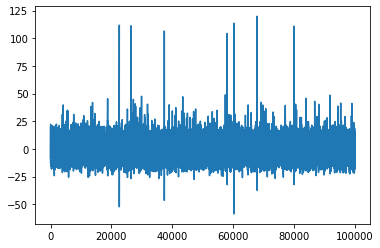

In [63]:
import numpy as np
import pylab as plt
trace = np.load('spike_sort/simulation_1.npy')
plt.plot(trace[:100000])
plt.show()

In [64]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    # extract spike waveforms
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [65]:
spike_samp, wave_form = get_spikes(trace, tf=5)

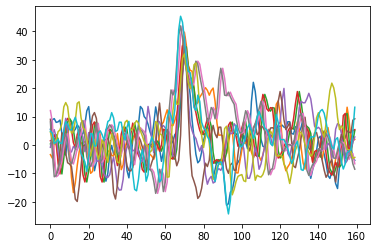

In [66]:
plt.plot(wave_form[:10].T)
plt.show()

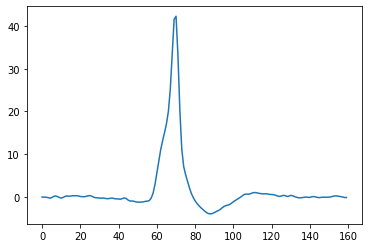

In [67]:
plt.plot(wave_form[:].mean(axis=0))

In [68]:
wave_form.shape

(1608, 160)

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(wave_form)

In [70]:
pca.explained_variance_ratio_

array([0.28233367, 0.15880909])

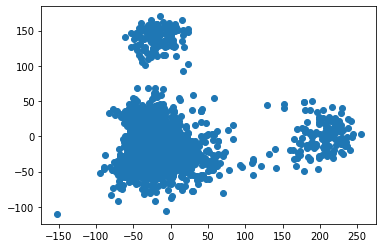

In [71]:
plt.scatter(X2D[:,0],X2D[:,1])

In [72]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X2D)
#Each instance was assigned to one of the 5 clusters:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [73]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

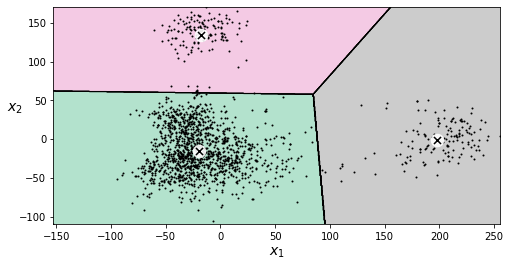

In [74]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X2D)
plt.show()

In [ ]:
# plot 3 groups
plt.figure(figsize=(12, 10))
color_list = ['r','g','b']
for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(wave_form[y_pred==i,:].T, color=color_list[i])
    plt.subplot(3, 2, 2*(i+1))
    plt.plot(wave_form[y_pred==i,:].T)
    

## Plot Intertia 

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X2D)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

## Plot Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_score(X2D, kmeans.labels_)

silhouette_scores = [silhouette_score(X2D, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [ ]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

# for k in (3, 4, 5, 6):
#     plt.subplot(2, 2, k - 2)
for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X2D, y_pred)

    padding = len(X2D) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

We can see that $k = 3$ seems to be the good choice in this case.